In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [2]:
from helper import *

In [3]:
init = tf.initializers.random_uniform(-0.5,0.5)

In [4]:
tf.reset_default_graph() 

In [5]:
def discriminator(inpt, reuse, name):
    with tf.variable_scope("Discriminator", reuse=reuse):
        dl1 = tf.layers.dense(inpt, 10, activation=tf.nn.relu, name="dl1", kernel_initializer=init)
        dl2 = tf.layers.dense( dl1, 10, activation=tf.nn.relu, name="dl2", kernel_initializer=init)
        dl3 = tf.layers.dense( dl2, 7, activation=tf.nn.relu, name="dl3", kernel_initializer=init)
        dis = tf.layers.dense( dl3, 1, name="dis")
        prob= tf.sigmoid(dis, name)
    return prob

In [6]:
inX = tf.placeholder(tf.float32, shape=[None, 2], name="X")
z  = tf.placeholder(tf.float32, shape=[None, 5], name="z")

In [7]:
dis = discriminator(inX, False, "discriminator")

In [8]:
with tf.variable_scope("Generator"):

    gl1 = tf.layers.dense(z,   10, activation=tf.nn.leaky_relu, name="gl1", kernel_initializer=init)
    gl2 = tf.layers.dense(gl1, 20, activation=tf.nn.leaky_relu, name="gl2", kernel_initializer=init)
    gl3 = tf.layers.dense(gl2, 10, activation=tf.nn.leaky_relu, name="gl3", kernel_initializer=init)
    gl4 = tf.layers.dense(gl3, 7, activation=tf.nn.leaky_relu, name="gl4", kernel_initializer=init)
    gen = tf.layers.dense(gl4, 2, name="gen")
    
combined = discriminator(gen, True, "combined")

In [9]:
gen_vars  = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="Discriminator")

In [10]:
gloss = tf.reduce_mean(tf.log(1 - combined))

In [11]:
dloss = - tf.reduce_mean(tf.log(dis) + tf.log(1 - combined))

In [12]:
writer = tf.summary.FileWriter('log/')
writer.add_graph(tf.get_default_graph())
writer.close()

In [13]:
train_gen = tf.train.AdamOptimizer(1e-3).minimize(gloss, var_list=gen_vars)
train_dis = tf.train.AdamOptimizer(1e-3).minimize(dloss, var_list=disc_vars)

In [14]:
data = np.concatenate((np.random.normal(-5, 3, size=(2000,2)),
                       np.random.normal(3, 2, size=(1000,2)),
                       np.random.multivariate_normal([-7, 7], [[1, 2], [2, 13]], 500),
                       np.random.multivariate_normal([5,-10], [[13, 2], [2, 1]], 500)))

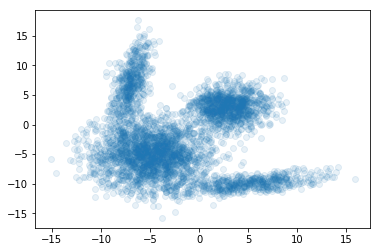

In [15]:
plt.scatter(data[:,0], data[:,1], alpha=0.1);

In [16]:
def sampleNoise(batch_size,rng=[-100, 100]):
    return np.random.uniform(rng[0], rng[1], (batch_size, 5))

In [17]:
def generate_data_for_dist(batch_size):
    real_data = data[np.random.choice(len(data), batch_size)]
    generated_data = sess.run(gen, feed_dict={})
    
    y = np.ones((2*batch_size, 1))
    y[:batch_size] = 0
    return np.concatenate((real_data, generated_data)),y

In [18]:
if "sess" in dir():
    sess.close()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [19]:
l = np.linspace(-20, 20, 100)
meshgrid = np.meshgrid(l, l)
l2 = np.array(meshgrid).T.reshape(-1, 2)

In [20]:
def plot():
    clear_output(wait=True)
    fig = plt.figure(figsize=(15,20))

    plt.subplot(411)
    plt.title("Loss")
    plt.plot(-glh, label="generator loss")
    plt.plot( dlh, label="discriminator loss")
#     plt.plot(glh + dlh, label="summary loss")
    plt.legend()

    plt.subplot(412)
    plt.title("Distributions")
    plt.scatter(data[:,0], data[:,1], alpha=0.1, label="Real distribution")
    plt.scatter(generated[:,0], generated[:,1], alpha=0.1, label="Generated distribution")
    plt.legend()
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)

    ax = fig.add_subplot(4, 1, 3, projection='3d')
    plt.title("Discriminator")
    surf = ax.plot_surface(meshgrid[0], meshgrid[1], out.reshape(meshgrid[0].shape))

    plt.subplot(414)
    plt.title("Real distribution")
    plt.scatter(generated[:,0], generated[:,1], alpha=0.1);

    plt.show()

In [21]:
def info():
    print("gen ", -gen_train_err)
    print("dis ", dis_train_err)
    print("epoch", len(glosshist))
    print("distance", np.abs(glosshist[-1] - glosshist[-2]) + np.abs(dlosshist[-1] - dlosshist[-2]))
#     print("has nan", np.any(np.isnan(generated)))
    print("generated")

In [22]:
maxIter = 3000
eps = 1e-200
batch_size = 20

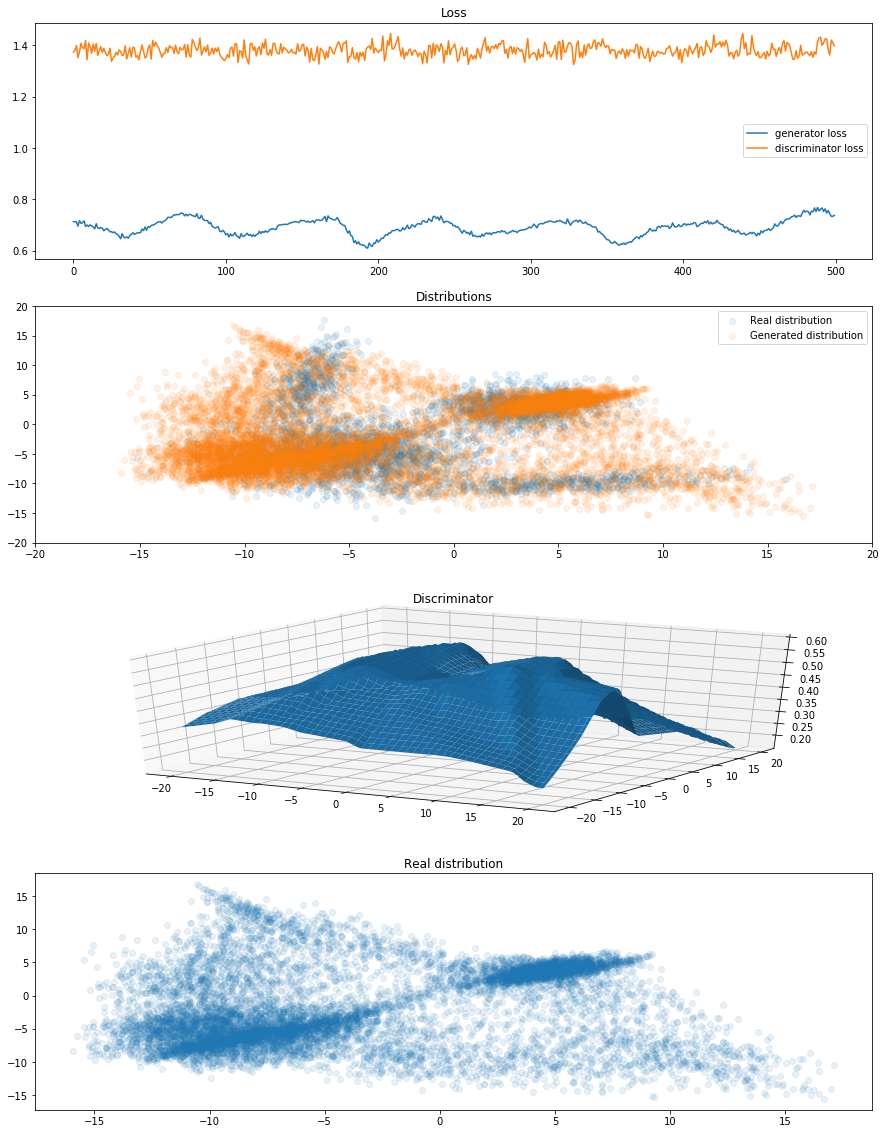

gen  0.7375689
dis  1.3982656
epoch 3000
distance 0.0170421
generated
[-4.966509   1.2195299]


In [23]:
glosshist=[]
dlosshist=[]

# with tf.device("/device:GPU:0"):
while len(glosshist)<2 or np.abs(glosshist[-1]-glosshist[-2]) + np.abs(dlosshist[-1]-dlosshist[-2]) > eps:
    X = data[np.random.choice(len(data),batch_size)]

    _, dis_train_err = sess.run([train_dis, dloss], feed_dict={inX: X, z: sampleNoise(batch_size)})
    _, gen_train_err = sess.run([train_gen, gloss], feed_dict={inX: X, z: sampleNoise(10*batch_size)})

    dlosshist.append(dis_train_err)
    glosshist.append(gen_train_err)

    out = sess.run(dis, feed_dict={inX: l2})
    generated = sess.run(gen, feed_dict={z: sampleNoise(10000,[-120,120])})

    if len(glosshist)%20 == 0:
        glh = np.array(glosshist[-500:])
        dlh = np.array(dlosshist[-500:])
        plot()
        info()

    print(generated[0])
    
    if len(glosshist) >= maxIter:
        break

In [24]:
allDone()